---
# Adam Talbot Scratch - Forecasting
---

## Imports

In [574]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# no yelling in the library
import warnings
warnings.filterwarnings("ignore")

# sklearn imports
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, explained_variance_score

# time series imports
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import Holt
from datetime import datetime

# pickle for reloading model object
import pickle

# visualization settings
plt.rc('figure', figsize=(13, 7))
plt.rc('font', size=16)
# sns.set_palette('tab20')
plt.style.use('seaborn-darkgrid')

# custom modules
import wrangle as w
import explore as e

---
## Clustering

In [575]:
# load model
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

KMeans(n_clusters=7, random_state=527)

In [576]:
# acquire and prep data
df = w.get_tx_data()
# subset data into a dictionary of dfs
industry_df_dict, ind_list = w.create_df_dict(df)
# charaterize series of data for each industry to make time series data into continuous data we can cluster on
char_df = e.create_char_df(industry_df_dict, ind_list)
# scale these characterizations for clustering
scaled_char_df = e.scale(char_df, MinMaxScaler())
# cluster and plot results
# char_df = e.load_cluster_and_plot_no_legend(loaded_model, scaled_char_df, char_df, df)

In [577]:
# char_df = e.load_cluster_and_plot_w_legend(loaded_model, scaled_char_df, char_df, df)

---
## Forecasting
---

#### Get dictionary of dfs for 12 industries we are interested in

In [578]:
def get_tx_data():
    '''
    Reads in raw data, filters, melts some columns to rows to get monthly observations, and creates datetime index
    '''
    df = pd.read_excel('QCEW-TX-L3-2016.xlsx') # get raw data
    # df = df[df.Ownership == 'Total All'] # filter just to all ownership groups
    df = df[['Year', 'Period', 'Industry Code', 'Industry', 'Month 1 Employment', 'Month 2 Employment', 'Month 3 Employment']] # only keep necessary columns
    df = df.melt(id_vars=['Year', 'Period', 'Industry Code', 'Industry'], var_name='Month', value_name='Total Employment') # melt columns to rows to get monthly instead of quarterly
    df['Month'] = df.Month.apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0]) # pull month integer out of string
    df['Date'] = df.apply(w.extract_date, axis=1) # use function to pull out date from multiple columns
    df.Date = pd.to_datetime(df.Date) # convert data to datetime dtype
    return df

In [579]:
def create_df_dict(df):
    '''
    Takes in df and creates a dictionary of series for all industries and the time interval we are interested in
    '''
    ind_list = df.Industry.value_counts().index.tolist() # get list of industries
    ind_list.remove('Monetary Authorities-Central Bank') # remove this industry since it has missing data
    ind_list.remove('Unclassified') # remove this industry since it is a catchall for a lot of unique industries that would be noise for our clustering
    industry_df_dict = {} # create empty df for dfs for each industry
    for ind in ind_list:
        industry_df_dict[ind] = df[df.Industry == ind][['Date', 'Total Employment']].set_index('Date')['Total Employment'].sort_index() # pull out series
    return industry_df_dict, ind_list

In [580]:
# get dictionary with all industries
# get all monthly data
df = get_tx_data()
# subset data into a dictionary of dfs
industry_df_dict, ind_list = create_df_dict(df)

In [581]:
forecast_ind_list = [
    'Performing Arts, Spectator Sports, and Related Industries',
    'Miscellaneous Store Retailers ',
    'Sporting Goods, Hobby, Musical Instrument, and Book Stores ',
    'Accommodation',
    'Food Services and Drinking Places',
    'Motion Picture and Sound Recording Industries',
    'Personal and Laundry Services',
    'Furniture and Home Furnishings Stores ',
    'Leather and Allied Product Manufacturing',
    'Amusement, Gambling, and Recreation Industries',
    'Scenic and Sightseeing Transportation',
    'Clothing and Clothing Accessories Stores '
]

In [582]:
len(forecast_ind_list)

12

In [583]:
forecast_ind_dict = {}
for ind in forecast_ind_list:
    forecast_ind_dict[ind] = industry_df_dict[ind]

In [584]:
len(forecast_ind_dict)

12

In [585]:
forecast_ind_dict['Clothing and Clothing Accessories Stores ']

Date
2016-01-01    115461
2016-02-01    111574
2016-03-01    112055
2016-04-01    110324
2016-05-01    110453
               ...  
2021-02-01     84663
2021-03-01     86150
2021-04-01     88391
2021-05-01     93523
2021-06-01     95838
Name: Total Employment, Length: 66, dtype: int64

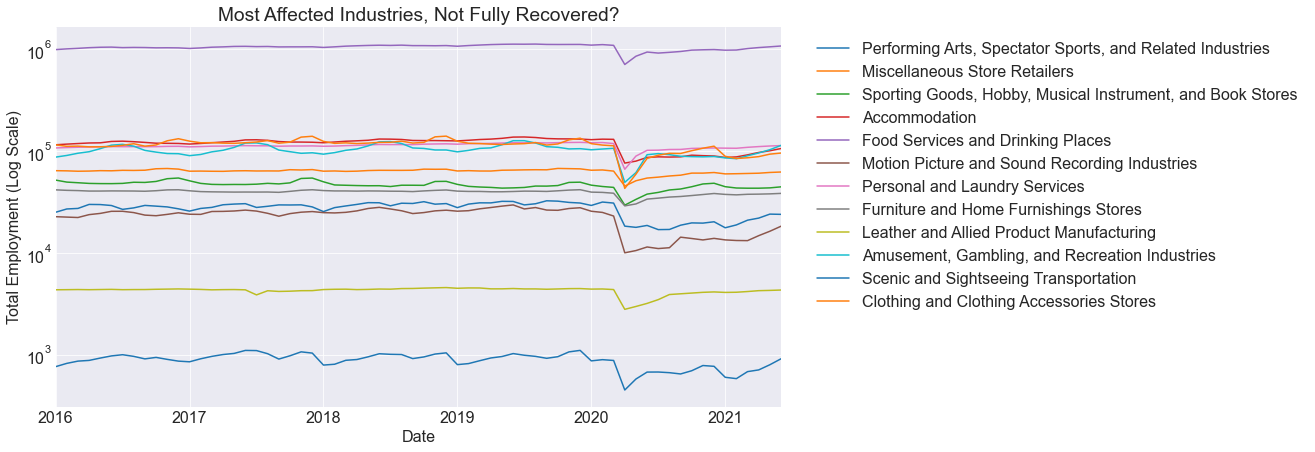

In [586]:
for ind in forecast_ind_list:
    forecast_ind_dict[ind].plot(label=ind)
plt.gca().set(ylabel = 'Total Employment (Log Scale)', title='Most Affected Industries, Not Fully Recovered?')
# plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.1f}M'.format(x / 1_000_000))
plt.yscale('log')
plt.legend(bbox_to_anchor= (1.03,1))
plt.show()

In [587]:
# create a metric of (June 2021 / June 2019) * 100

In [588]:
def characterize_series(s):
    '''
    Takes in a series of times series data and characterizes it based on it's behavior over a specified interval
    '''
    recovery = (s['2021-06'][0] / s['2019-06'][0]) * 100
    characteristic_dict = {
        'recovery' : recovery
    }
    return characteristic_dict

In [589]:
def create_char_df(industry_df_dict):
    '''
    Creates a pandas df of characterstics of section of times series data
    '''
    characteristics = [] # create empty list for list of dictionaries
    ind_list = list(industry_df_dict.keys())
    for ind in ind_list: # loop through industries
        s = industry_df_dict[ind] # characterize them each using function
        characteristics.append(characterize_series(s)) # append to list of dicts
    char_df = pd.DataFrame(characteristics, index=ind_list) # convert to df
    return char_df

##### % Recovered Table 

In [590]:
create_char_df(forecast_ind_dict).sort_values(by='recovery')

,recovery
Motion Picture and Sound Recording Industries,61.763515
"Performing Arts, Spectator Sports, and Related Industries",74.684926
Accommodation,77.209860
Clothing and Clothing Accessories Stores,81.494898
Scenic and Sightseeing Transportation,88.888889
"Amusement, Gambling, and Recreation Industries",89.903270
Personal and Laundry Services,93.778813
Miscellaneous Store Retailers,95.706924
Furniture and Home Furnishings Stores,95.801793
Food Services and Drinking Places,95.909662


---
### Resumption
---

####  Sporting Goods, Hobby, Musical Instrument, and Book Stores

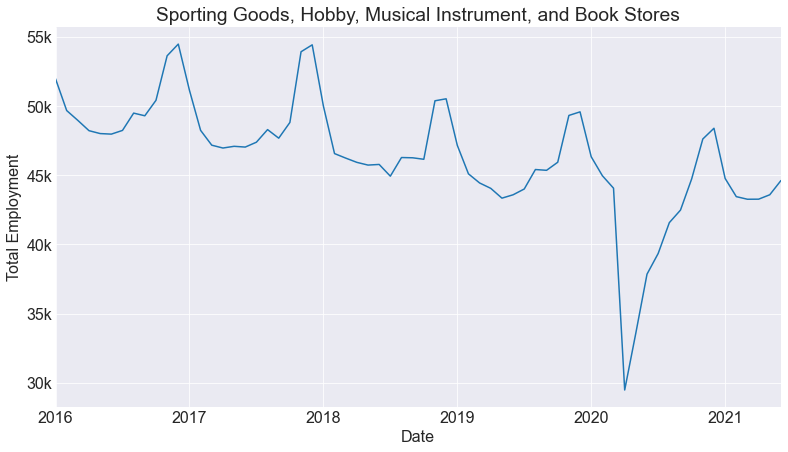

In [591]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_sporting = forecast_ind_dict['Sporting Goods, Hobby, Musical Instrument, and Book Stores ']
s_sporting.plot()
plt.gca().set(ylabel = 'Total Employment', title='Sporting Goods, Hobby, Musical Instrument, and Book Stores')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Splits

In [592]:
train = s_sporting['2016' : '2018']
# validate = s_sporting['2018']
test = s_sporting['2019']

In [593]:
# create a function to visualize splits
def viz_splits(train, test):
    ax = train.plot(label='train')
    # validate.plot(ax=ax, label='validate')
    test.plot(ax=ax, label='test')
    plt.legend()
    plt.title('Visualizing Splits')
    plt.ylabel('Total Employment')
    ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.show();

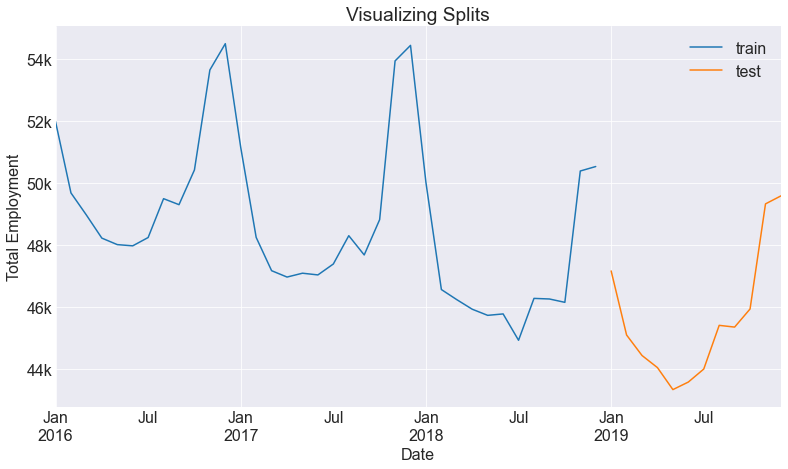

In [594]:
viz_splits(train, test)

##### Seasonal Decomp 

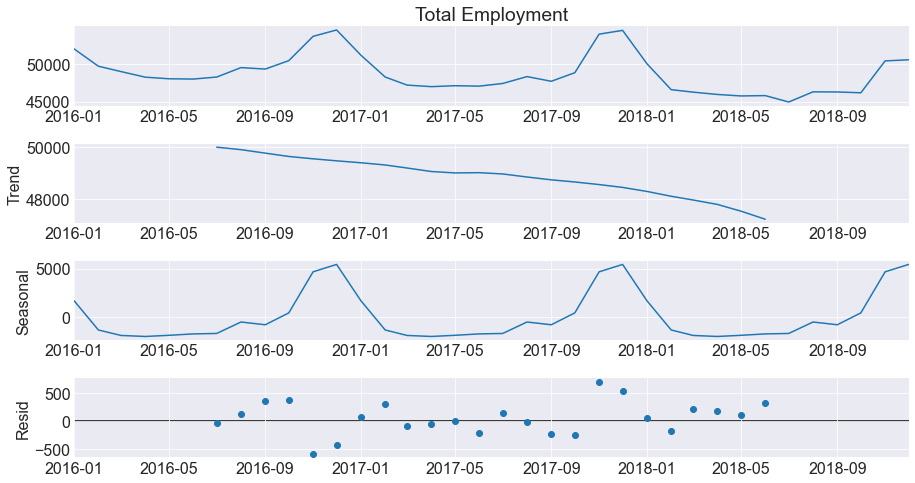

In [595]:
_ = sm.tsa.seasonal_decompose(train).plot()

##### Forecast

In [596]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

In [597]:
train.diff(12).mean()

-1482.7916666666667

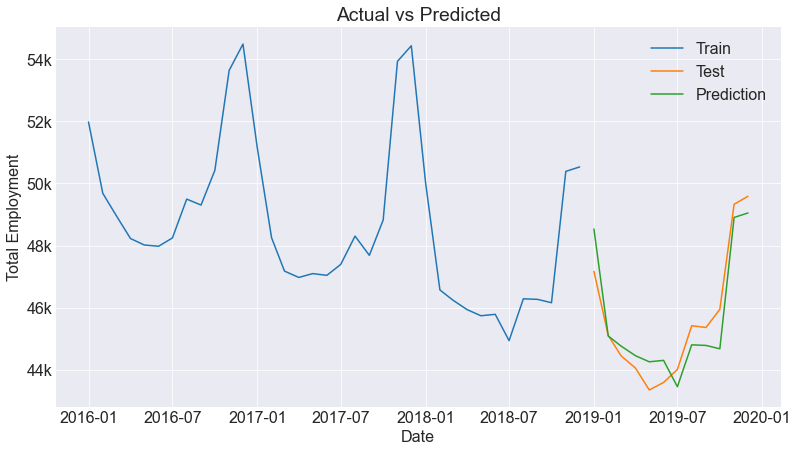

In [598]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [599]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

738.7250195532088

In [600]:
# get R^2
explained_variance_score(test, forecast)

0.8638711606813445

In [601]:
# predict the future
# want to predict 1.5 years into future to get us to end of year 2022
# get values for 1.5 years preceding pandemic 2018-07 to 2019-12
historical = s_sporting['2018-07' : '2019-12']

In [602]:
# want to get index that goes from July 2021 to Dec 2022

future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq=None)

In [603]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

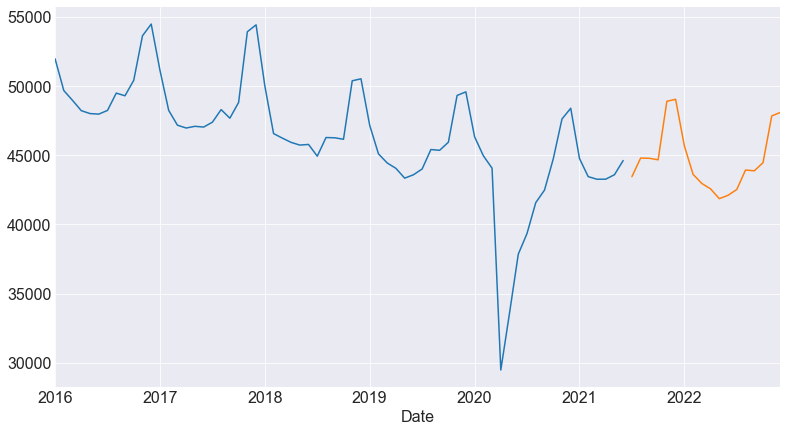

In [604]:
s_sporting.plot()
future.plot()

##### Final Plot

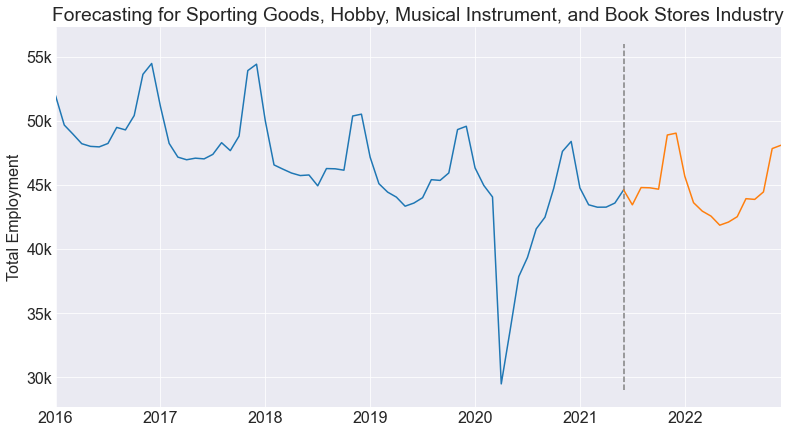

In [605]:
pd.concat([s_sporting, future])[: '2021-06'].plot()
pd.concat([s_sporting, future])['2021-06' : ].plot()
plt.vlines(x='2021-06', ymin=29_000, ymax=56_000, linestyles='--', colors='gray')
plt.gca().set(title='Forecasting for Sporting Goods, Hobby, Musical Instrument, and Book Stores Industry', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
### Recovery and Resumption
---

####  Motion Picture and Sound Recording Industries

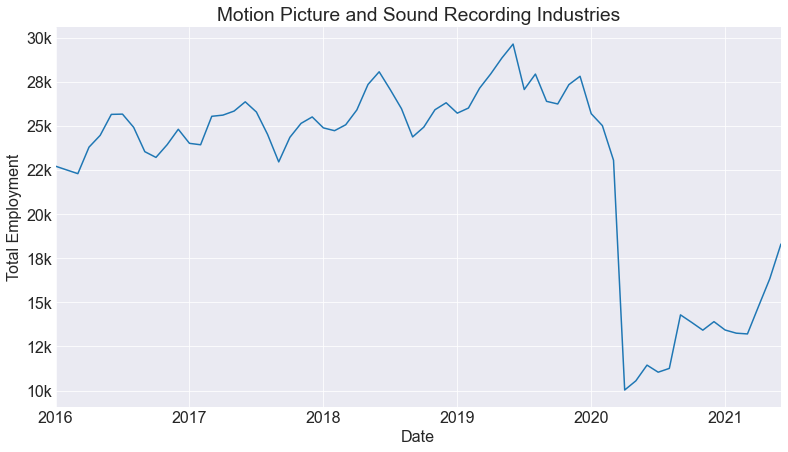

In [687]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_motion = forecast_ind_dict['Motion Picture and Sound Recording Industries']
s_motion.plot()
plt.gca().set(ylabel = 'Total Employment', title='Motion Picture and Sound Recording Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Just use slope

In [688]:
# find min to figure out where it bottomed out
s_motion[s_motion == s_motion.min()]

Date
2020-04-01    10034
Name: Total Employment, dtype: int64

In [689]:
# now I want to find slope from April to most recent data point
# April 2020 to June 2021 = 14 months
train = s_motion['2020-04' : ]
months = len(train) - 1

In [690]:
train

Date
2020-04-01    10034
2020-05-01    10553
2020-06-01    11444
2020-07-01    11043
2020-08-01    11258
2020-09-01    14291
2020-10-01    13866
2020-11-01    13424
2020-12-01    13907
2021-01-01    13433
2021-02-01    13254
2021-03-01    13211
2021-04-01    14784
2021-05-01    16336
2021-06-01    18303
Name: Total Employment, dtype: int64

In [691]:
# take the last value minus the first value
emp_delta = train[-1] - train[0]

In [692]:
emp_delta / months

590.6428571428571

In [693]:
# get dates to apply slope to
future_index_str = [
    '2020-04',
    '2020-05',
    '2020-06',
    '2020-07',
    '2020-08',
    '2020-09',
    '2020-10',
    '2020-11', 
    '2020-12', 
    '2021-01', 
    '2021-02', 
    '2021-03',
    '2021-04',
    '2021-05',
    '2021-06',
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11',
    '2021-12',
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01'],
              dtype='datetime64[ns]', freq=None)

In [694]:
len(future_index)

33

In [695]:
# write a function that takes in the first value, the slope, and calculates each value moving forward n months
numbers = [10034]
slope = emp_delta / months
for month in range(32):
    new = numbers[-1] + slope
    numbers.append(new)

In [696]:
slope_prediction = pd.Series(data=numbers, index=future_index)

<AxesSubplot:xlabel='Date'>

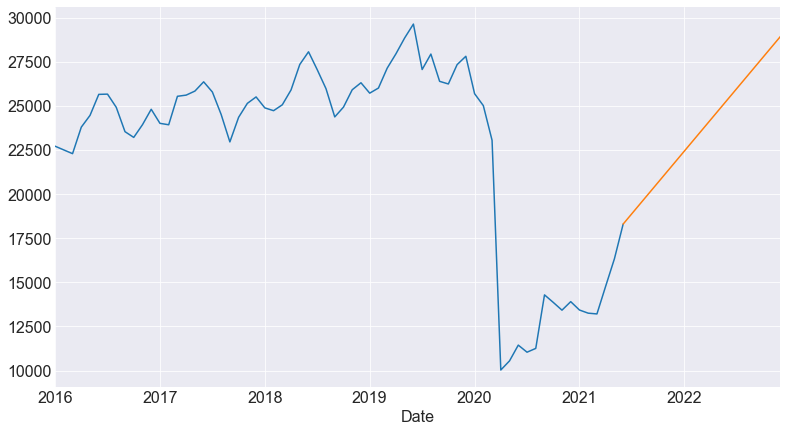

In [698]:
s_motion.plot()
slope_prediction['2021-06' : ].plot()

In [700]:
# figure out when recovery happens
s_motion['2019']

Date
2019-01-01    25720
2019-02-01    26010
2019-03-01    27136
2019-04-01    27948
2019-05-01    28849
2019-06-01    29634
2019-07-01    27059
2019-08-01    27935
2019-09-01    26389
2019-10-01    26241
2019-11-01    27336
2019-12-01    27810
Name: Total Employment, dtype: int64

In [702]:
slope_prediction['2021-06' :]

2021-06-01    18303.000000
2021-07-01    18893.642857
2021-08-01    19484.285714
2021-09-01    20074.928571
2021-10-01    20665.571429
2021-11-01    21256.214286
2021-12-01    21846.857143
2022-01-01    22437.500000
2022-02-01    23028.142857
2022-03-01    23618.785714
2022-04-01    24209.428571
2022-05-01    24800.071429
2022-06-01    25390.714286
2022-07-01    25981.357143
2022-08-01    26572.000000
2022-09-01    27162.642857
2022-10-01    27753.285714
2022-11-01    28343.928571
2022-12-01    28934.571429
dtype: float64

Recovery happens 2022-09

Use slope prediction from 2021-07 to 2022-09

In [713]:
# resume seasonal behavior from 2022-10 to 2023-12
train = s_motion['2016' : '2018']

In [714]:
# predict the future
historical = s_motion['2018-10' : '2019-12']

In [715]:
# define future index
future_index_str = [
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01',
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [716]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

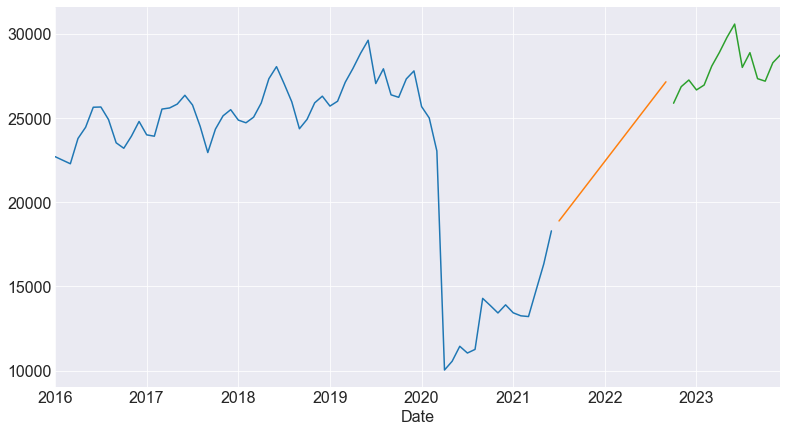

In [720]:
s_motion.plot()
slope_prediction['2021-07' : '2022-09'].plot()
future.plot()

##### Final Plot

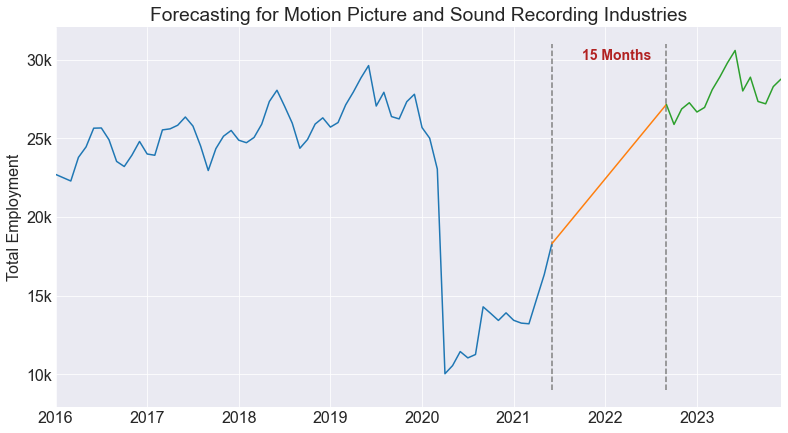

In [727]:
full_forecast = pd.concat([s_motion, slope_prediction['2021-07' : '2022-09'], future])
full_forecast[ : '2021-06'].plot() # data we have
full_forecast['2021-06' : '2022-09'].plot() # linear recovery forecast
full_forecast['2022-09' : ].plot() # resumption forecast
plt.vlines(x='2021-06', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.vlines(x='2022-09', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.text('2021-10', 30_000, '15 Months', fontsize=14, color='firebrick', fontweight='bold')
plt.gca().set(title='Forecasting for Motion Picture and Sound Recording Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

---
##### Holt's Linear Trend

In [607]:
s_motion[s_motion == s_motion.min()]

Date
2020-04-01    10034
Name: Total Employment, dtype: int64

In [608]:
# define train set for this model
train = s_motion['2020-04' : ]
train

Date
2020-04-01    10034
2020-05-01    10553
2020-06-01    11444
2020-07-01    11043
2020-08-01    11258
2020-09-01    14291
2020-10-01    13866
2020-11-01    13424
2020-12-01    13907
2021-01-01    13433
2021-02-01    13254
2021-03-01    13211
2021-04-01    14784
2021-05-01    16336
2021-06-01    18303
Name: Total Employment, dtype: int64

In [682]:
# define future index for this model
# want to get index that goes from July 2021 to Dec 2022
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

<AxesSubplot:xlabel='Date'>

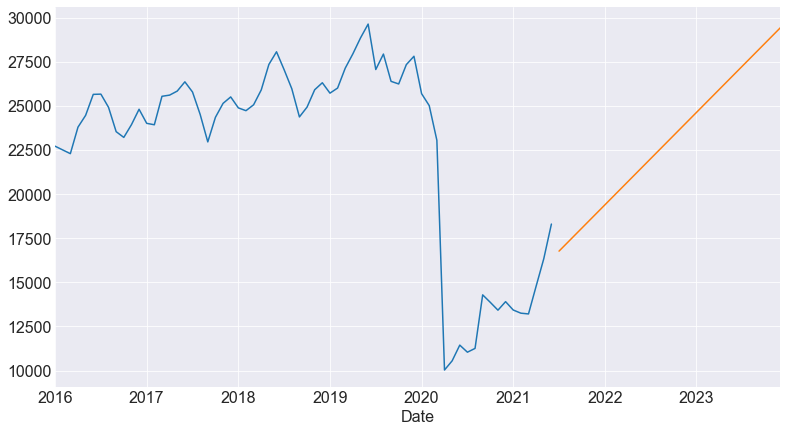

In [683]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0, 
                  smoothing_trend = 0,
                  optimized = True)
holts = model.predict(start = future_index[0], end = future_index[-1])
s_motion.plot()
holts.plot()

<AxesSubplot:xlabel='Date'>

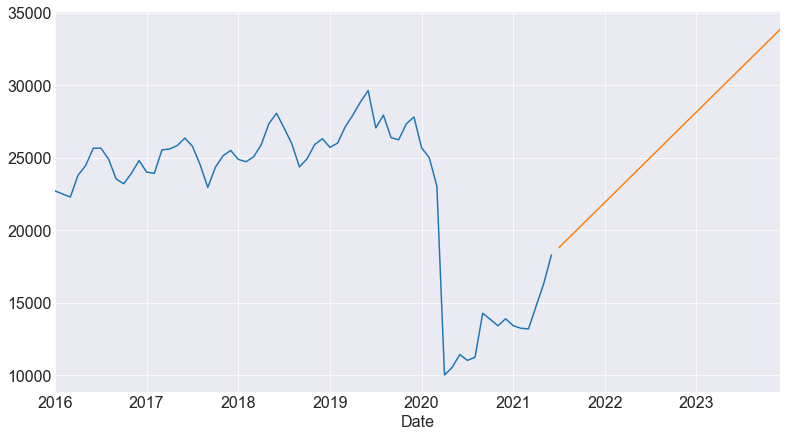

In [611]:
model = Holt(train)
model = model.fit()
holts = model.predict(start = future_index[0],
              end = future_index[-1])
s_motion.plot()
holts.plot()

In [453]:
# get values that indicate recovery
s_motion['2019']

Date
2019-01-01    25720
2019-02-01    26010
2019-03-01    27136
2019-04-01    27948
2019-05-01    28849
2019-06-01    29634
2019-07-01    27059
2019-08-01    27935
2019-09-01    26389
2019-10-01    26241
2019-11-01    27336
2019-12-01    27810
Name: Total Employment, dtype: int64

In [454]:
holts

2021-07-01    18814.781369
2021-08-01    19333.829184
2021-09-01    19852.876998
2021-10-01    20371.924813
2021-11-01    20890.972628
2021-12-01    21410.020442
2022-01-01    21929.068257
2022-02-01    22448.116071
2022-03-01    22967.163886
2022-04-01    23486.211700
2022-05-01    24005.259515
2022-06-01    24524.307330
2022-07-01    25043.355144
2022-08-01    25562.402959
2022-09-01    26081.450773
2022-10-01    26600.498588
2022-11-01    27119.546402
2022-12-01    27638.594217
2023-01-01    28157.642032
2023-02-01    28676.689846
2023-03-01    29195.737661
2023-04-01    29714.785475
2023-05-01    30233.833290
2023-06-01    30752.881105
2023-07-01    31271.928919
2023-08-01    31790.976734
2023-09-01    32310.024548
2023-10-01    32829.072363
2023-11-01    33348.120177
2023-12-01    33867.167992
Freq: MS, dtype: float64

**Recovery date is 2022-10**

In [455]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01'],
              dtype='datetime64[ns]', freq=None)

<AxesSubplot:xlabel='Date'>

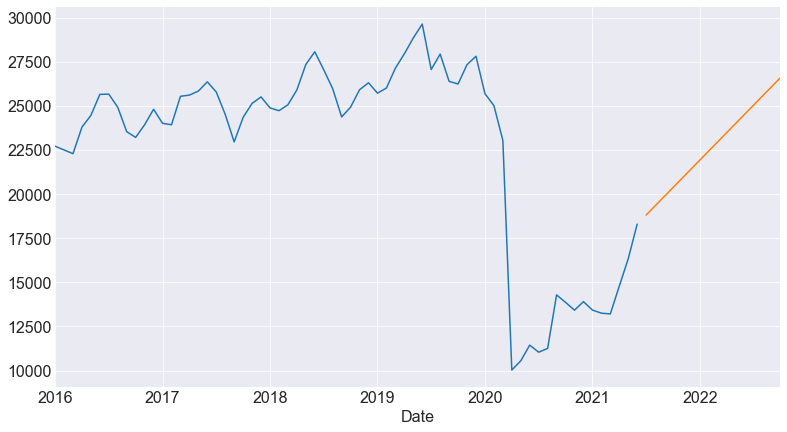

In [456]:
# make adjusted predictions
holts = model.predict(start = future_index[0], end = future_index[-1])
s_motion.plot()
holts.plot()

##### Last normal season 

In [310]:
# now resume previous behavior?

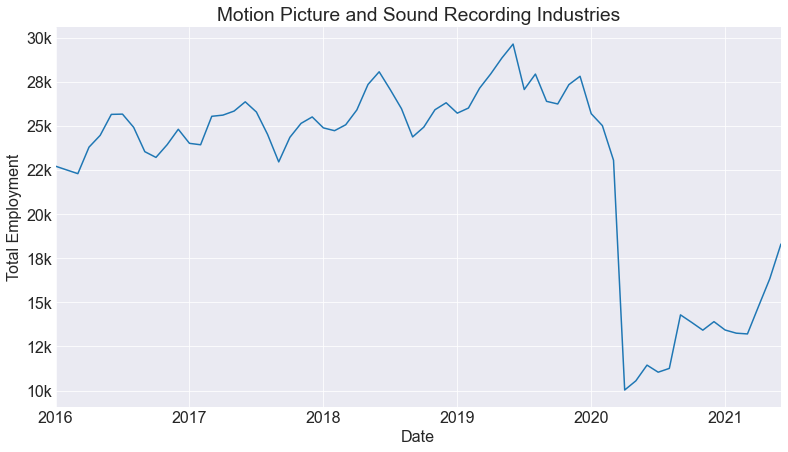

In [311]:
# forecast pre-COVID behavior after full recovery
s_motion = forecast_ind_dict['Motion Picture and Sound Recording Industries']
s_motion.plot()
plt.gca().set(ylabel = 'Total Employment', title='Motion Picture and Sound Recording Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Splits

In [312]:
train = s_motion['2016' : '2018']
test = s_motion['2019']

In [313]:
# create a function to visualize splits
def viz_splits(train, test):
    ax = train.plot(label='train')
    test.plot(ax=ax, label='test')
    plt.legend()
    plt.title('Visualizing Splits')
    plt.ylabel('Total Employment')
    ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.show();

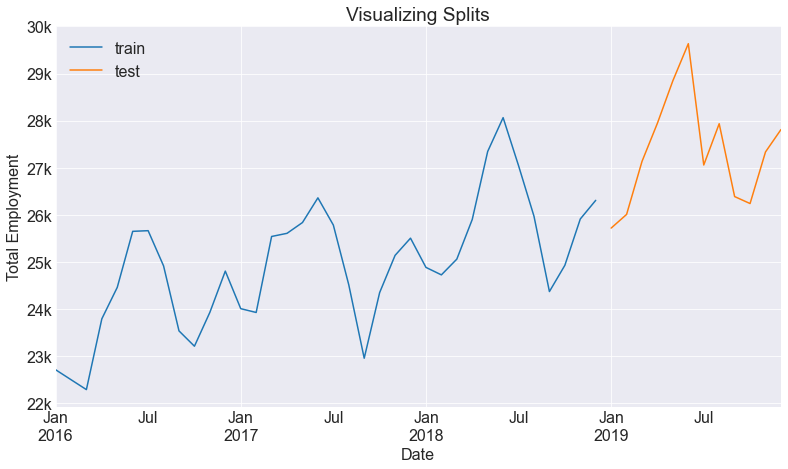

In [314]:
viz_splits(train, test)

##### Seasonal Decomp 

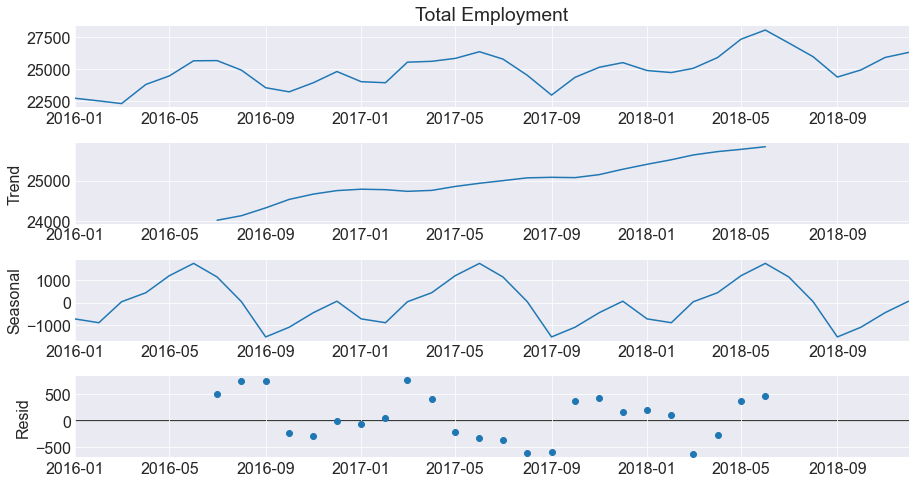

In [315]:
_ = sm.tsa.seasonal_decompose(train).plot()

##### Forecast

In [316]:
forecast = train['2018'] + train.diff(12).mean()
forecast.index = test.index

In [317]:
train.diff(12).mean()

959.9583333333334

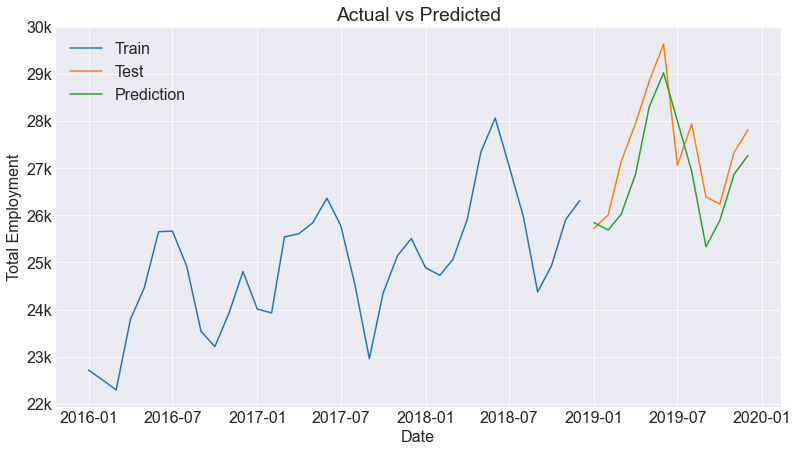

In [318]:
plt.plot(train, label='Train')
#plt.plot(validate, label='Validate')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [319]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

755.7787110453997

In [320]:
# get R^2
explained_variance_score(test, forecast)

0.7461388782842269

In [321]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_motion['2018-11' : '2019-12']

In [325]:
# want to get index that goes from July 2021 to Dec 2022

future_index_str = [
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [326]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

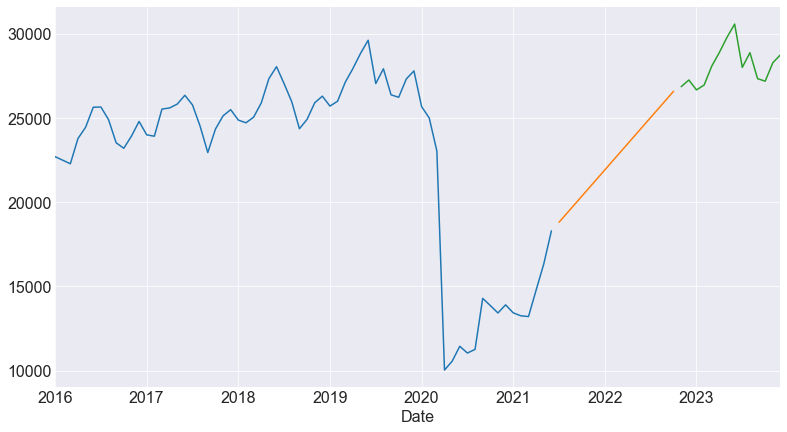

In [327]:
s_motion.plot()
holts.plot()
future.plot()

##### Final Plot

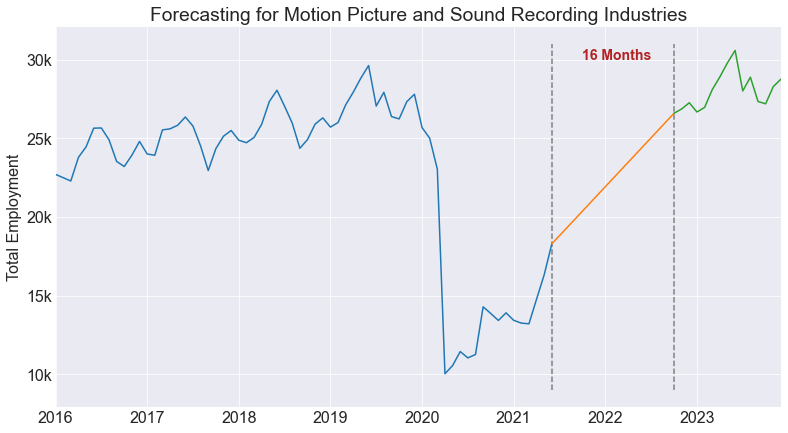

In [335]:
full_forecast = pd.concat([s_motion, holts, future])
full_forecast[ : '2021-06'].plot() # data we have
full_forecast['2021-06' : '2022-10'].plot() # linear recovery forecast
full_forecast['2022-10' : ].plot() # resumption forecast
plt.vlines(x='2021-06', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.vlines(x='2022-10', ymin=9_000, ymax=31_000, linestyles='--', colors='gray')
plt.text('2021-10', 30_000, '16 Months', fontsize=14, color='firebrick', fontweight='bold')
plt.gca().set(title='Forecasting for Motion Picture and Sound Recording Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
####  Performing Arts, Spectator Sports, and Related Industries

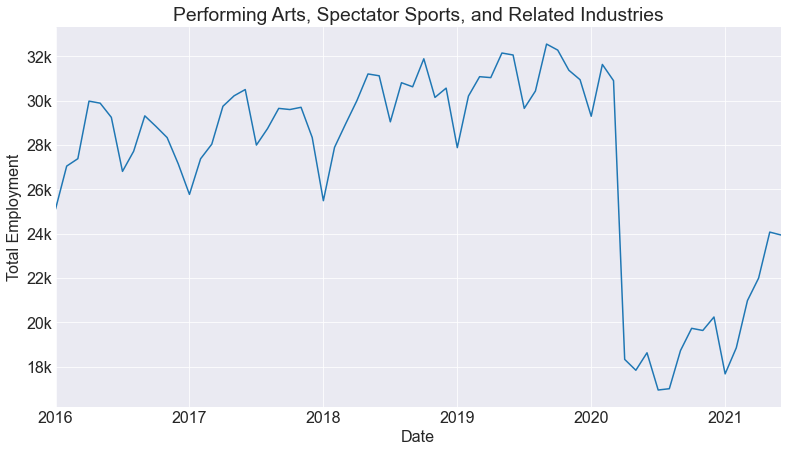

In [552]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_perform = forecast_ind_dict['Performing Arts, Spectator Sports, and Related Industries']
s_perform.plot()
plt.gca().set(ylabel = 'Total Employment', title='Performing Arts, Spectator Sports, and Related Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Holt's Linear Trend

In [553]:
# find min value where employment bottomed out and recovery started
s_perform[s_perform == s_perform.min()]

Date
2020-07-01    16953
Name: Total Employment, dtype: int64

In [554]:
# define train set for this model
train = s_perform['2020-07' : ]
train

Date
2020-07-01    16953
2020-08-01    17011
2020-09-01    18730
2020-10-01    19734
2020-11-01    19637
2020-12-01    20244
2021-01-01    17679
2021-02-01    18854
2021-03-01    20984
2021-04-01    21998
2021-05-01    24072
2021-06-01    23941
Name: Total Employment, dtype: int64

In [555]:
# define future index for this model
# want to get index that goes from July 2021 to Dec 2022
# after we find recovery date, we will trim index accordingly

future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', freq=None)

<AxesSubplot:xlabel='Date'>

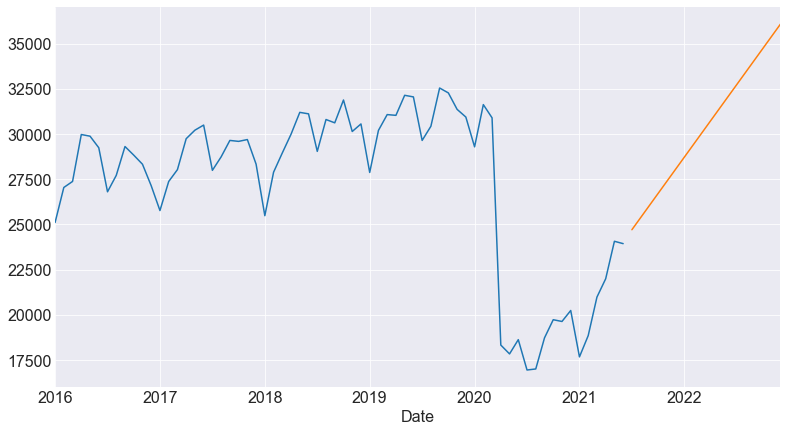

In [556]:
model = Holt(train, exponential = False)
model = model.fit(optimized = True)
holts = model.predict(start = future_index[0],
              end = future_index[-1])
s_perform.plot()
holts.plot()

<AxesSubplot:xlabel='Date'>

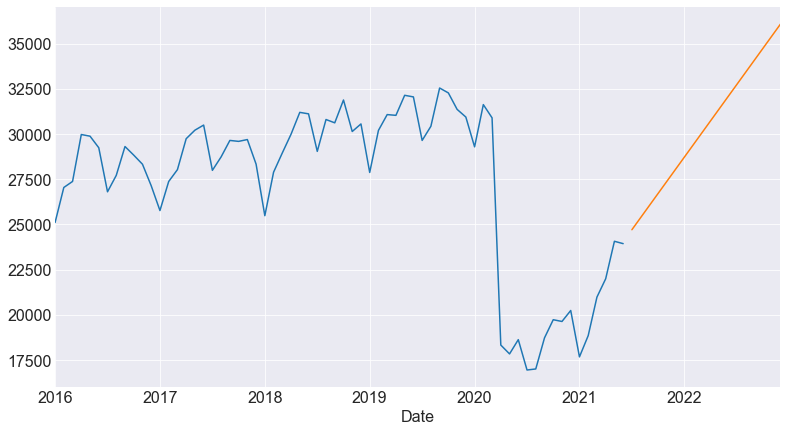

In [557]:
model = Holt(train)
model = model.fit()
holts = model.predict(start = future_index[0],
              end = future_index[-1])
s_perform.plot()
holts.plot()

In [367]:
# get values that indicate recovery
s_perform['2019']

Date
2019-01-01    27878
2019-02-01    30204
2019-03-01    31078
2019-04-01    31036
2019-05-01    32145
2019-06-01    32056
2019-07-01    29649
2019-08-01    30431
2019-09-01    32548
2019-10-01    32276
2019-11-01    31367
2019-12-01    30942
Name: Total Employment, dtype: int64

In [368]:
holts

2021-07-01    24711.080393
2021-08-01    25380.058068
2021-09-01    26049.035743
2021-10-01    26718.013417
2021-11-01    27386.991092
2021-12-01    28055.968767
2022-01-01    28724.946442
2022-02-01    29393.924117
2022-03-01    30062.901791
2022-04-01    30731.879466
2022-05-01    31400.857141
2022-06-01    32069.834816
2022-07-01    32738.812491
2022-08-01    33407.790166
2022-09-01    34076.767840
2022-10-01    34745.745515
2022-11-01    35414.723190
2022-12-01    36083.700865
Freq: MS, dtype: float64

**Recovery date is 2022-06**

In [369]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'],
              dtype='datetime64[ns]', freq=None)

<AxesSubplot:xlabel='Date'>

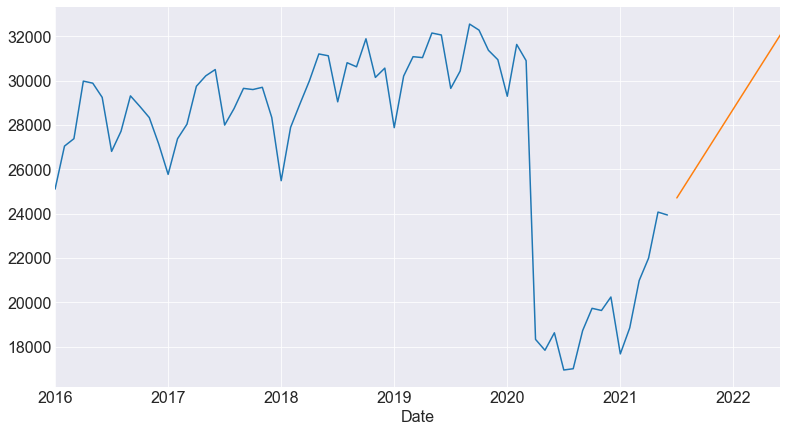

In [371]:
# make adjusted predictions
holts = model.predict(start = future_index[0], end = future_index[-1])
s_perform.plot()
holts.plot()

##### Last normal season 

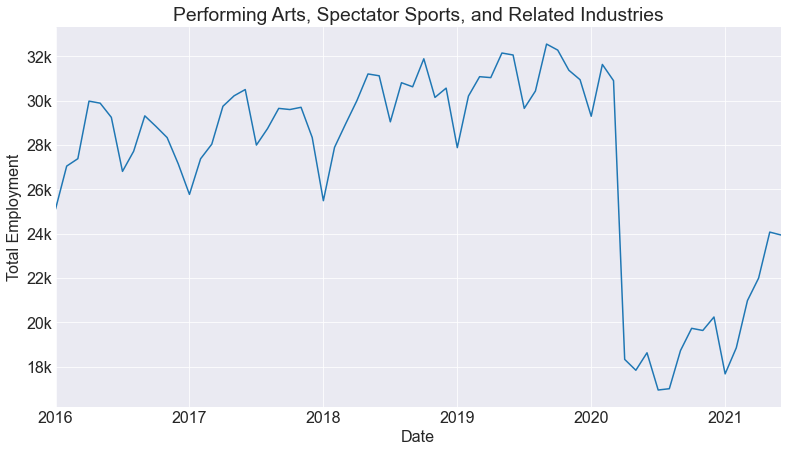

In [372]:
# forecast pre-COVID behavior after full recovery
s_perform = forecast_ind_dict['Performing Arts, Spectator Sports, and Related Industries']
s_perform.plot()
plt.gca().set(ylabel = 'Total Employment', title='Performing Arts, Spectator Sports, and Related Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Splits

In [373]:
train = s_perform['2016' : '2018']
test = s_perform['2019']

In [374]:
# create a function to visualize splits
def viz_splits(train, test):
    ax = train.plot(label='train')
    test.plot(ax=ax, label='test')
    plt.legend()
    plt.title('Visualizing Splits')
    plt.ylabel('Total Employment')
    ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.show();

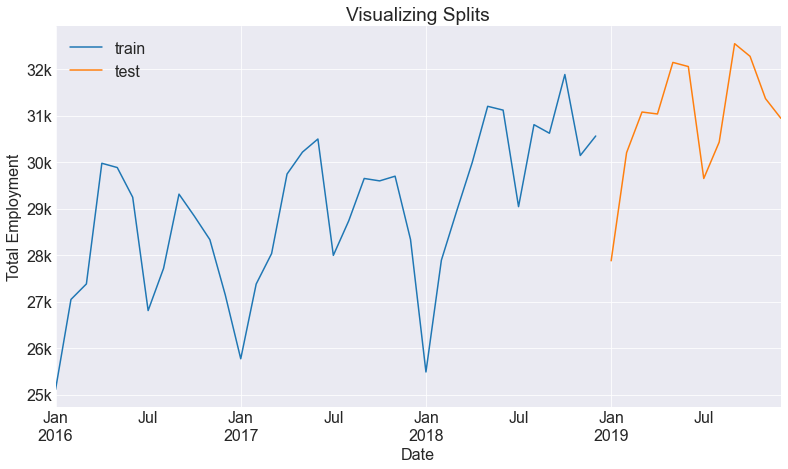

In [375]:
viz_splits(train, test)

##### Seasonal Decomp 

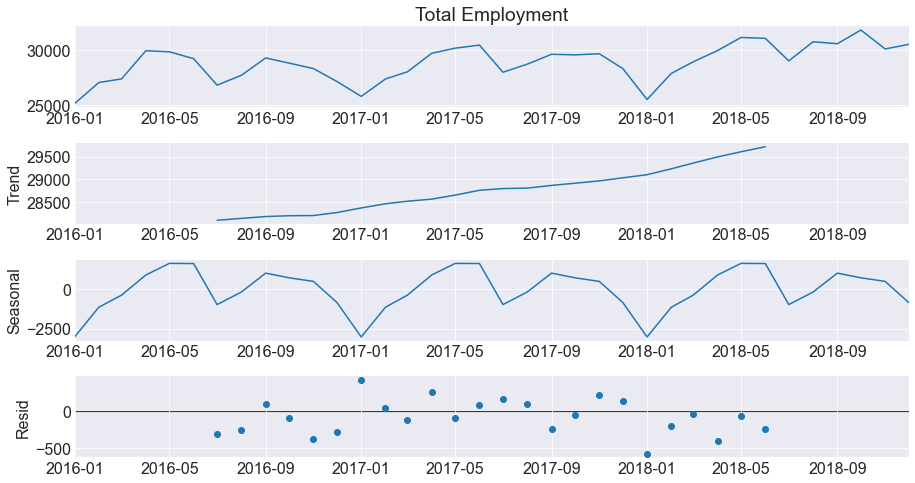

In [376]:
_ = sm.tsa.seasonal_decompose(train).plot()

##### Forecast and Test

In [390]:
forecast = train['2016'] + 3*(train.diff(12).mean())
forecast.index = test.index

In [391]:
train.diff(12).mean()

871.75

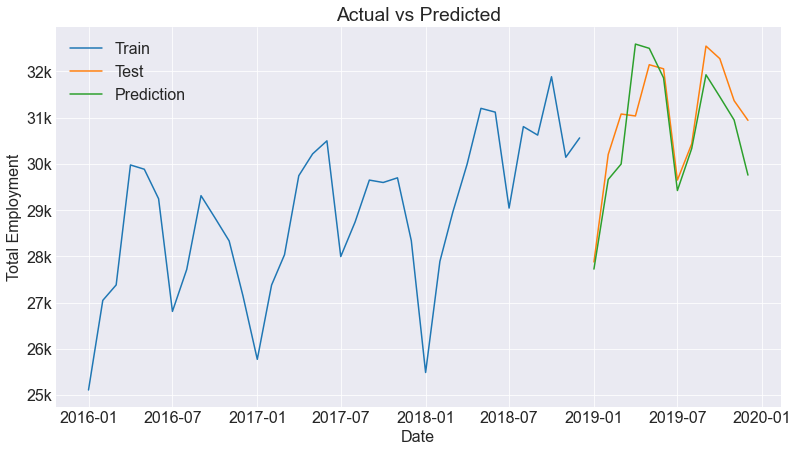

In [392]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [393]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

751.4251875602787

In [394]:
# get R^2
explained_variance_score(test, forecast)

0.697056465451893

##### Predict Future

In [397]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_perform['2018-07' : '2019-12']

In [398]:
# want to get index that goes from July 2021 to Dec 2022

future_index_str = [
    '2022-07', 
    '2022-08',
    '2022-09', 
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [399]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

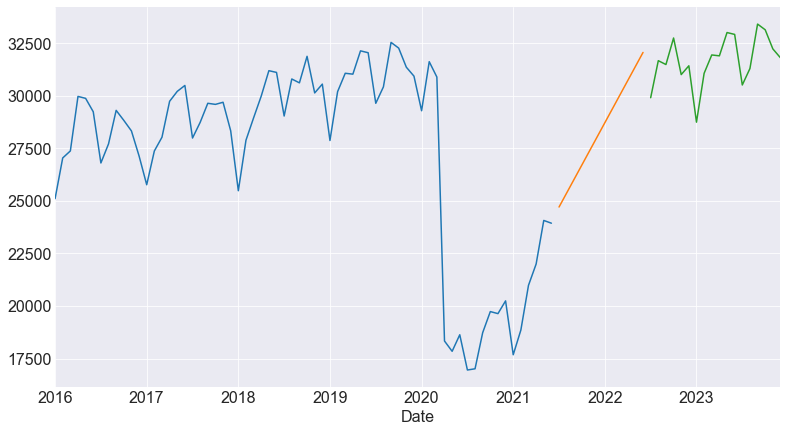

In [400]:
s_perform.plot()
holts.plot()
future.plot()

##### Final Plot

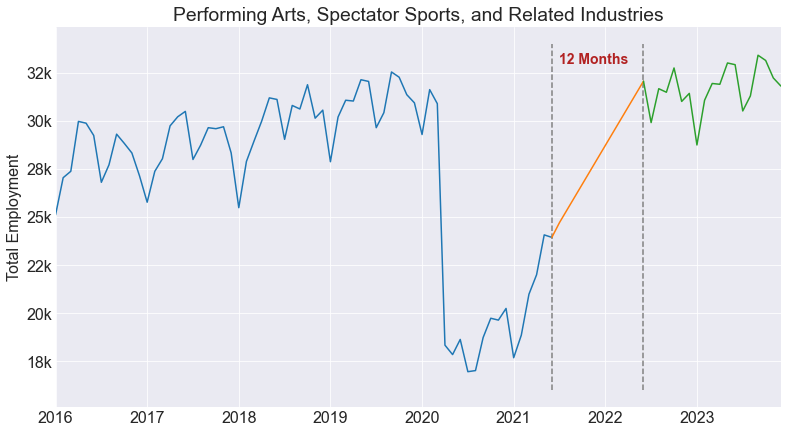

In [416]:
full_forecast = pd.concat([s_perform, holts, future])
full_forecast[ : '2021-06'].plot() # data we have
full_forecast['2021-06' : '2022-06'].plot() # linear recovery forecast
full_forecast['2022-06' : ].plot() # resumption forecast
plt.vlines(x='2021-06', ymin=16_000, ymax=34_000, linestyles='--', colors='gray')
plt.vlines(x='2022-06', ymin=16_000, ymax=34_000, linestyles='--', colors='gray')
plt.text('2021-07', 33_000, '12 Months', fontsize=14, color='firebrick', fontweight='bold')
plt.gca().set(title='Performing Arts, Spectator Sports, and Related Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

----
####  Accommodation

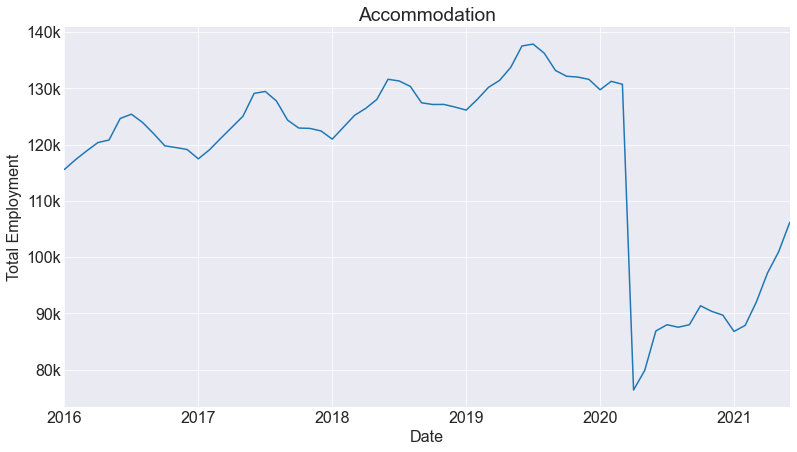

In [558]:
# forecast pre-COVID behavior after full recovery for Sporting Goods industry
s_accom = forecast_ind_dict['Accommodation']
s_accom.plot()
plt.gca().set(ylabel = 'Total Employment', title='Accommodation')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Holt's Linear Trend

In [559]:
# find min value where employment bottomed out and recovery started
s_accom[s_accom == s_accom.min()]

Date
2020-04-01    76362
Name: Total Employment, dtype: int64

In [560]:
# define train set for this model
train = s_accom['2020-04' : ]
train

Date
2020-04-01     76362
2020-05-01     79845
2020-06-01     86858
2020-07-01     87968
2020-08-01     87520
2020-09-01     87964
2020-10-01     91336
2020-11-01     90345
2020-12-01     89669
2021-01-01     86772
2021-02-01     87850
2021-03-01     91993
2021-04-01     97152
2021-05-01    100932
2021-06-01    106179
Name: Total Employment, dtype: int64

In [561]:
# define future index for this model
# want to get index that goes from July 2021 to Dec 2022
# after we find recovery date, we will trim index accordingly

future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    '2022-07',
    '2022-08',
    '2022-09',
    '2022-10',
    '2022-11',
    '2022-12',
    ]

future_index = pd.to_datetime(future_index_str)

<AxesSubplot:xlabel='Date'>

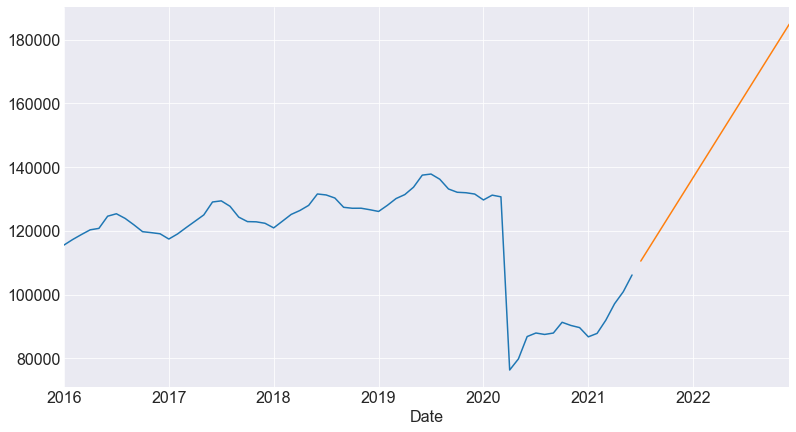

In [563]:
model = Holt(train)
model = model.fit()
holts = model.predict(start = future_index[0],
              end = future_index[-1])
s_accom.plot()
holts.plot()

<AxesSubplot:xlabel='Date'>

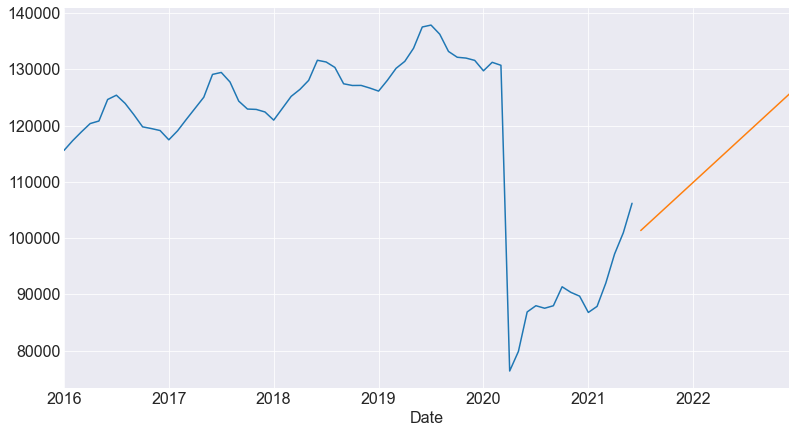

In [564]:
model = Holt(train, exponential = False)
model = model.fit(smoothing_level = 0,
                  smoothing_slope = 0,
                  damping_trend = 0,
                  optimized=True)
holts = model.predict(start = future_index[0],
              end = future_index[-1])
s_accom.plot()
holts.plot()

In [475]:
# get values that indicate recovery
s_perform['2019']

Date
2019-01-01    27878
2019-02-01    30204
2019-03-01    31078
2019-04-01    31036
2019-05-01    32145
2019-06-01    32056
2019-07-01    29649
2019-08-01    30431
2019-09-01    32548
2019-10-01    32276
2019-11-01    31367
2019-12-01    30942
Name: Total Employment, dtype: int64

In [476]:
holts

2021-07-01    101152.826711
2021-08-01    102573.500865
2021-09-01    103994.175020
2021-10-01    105414.849175
2021-11-01    106835.523329
2021-12-01    108256.197484
2022-01-01    109676.871639
2022-02-01    111097.545793
2022-03-01    112518.219948
2022-04-01    113938.894103
2022-05-01    115359.568258
2022-06-01    116780.242412
2022-07-01    118200.916567
2022-08-01    119621.590722
2022-09-01    121042.264876
2022-10-01    122462.939031
2022-11-01    123883.613186
2022-12-01    125304.287340
Freq: MS, dtype: float64

**Recovery date is 2022-06**

In [369]:
# redefine future index based on when recovery occured
future_index_str = [
    '2021-07',
    '2021-08',
    '2021-09',
    '2021-10',
    '2021-11', 
    '2021-12', 
    '2022-01', 
    '2022-02', 
    '2022-03',
    '2022-04',
    '2022-05',
    '2022-06',
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01',
               '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01'],
              dtype='datetime64[ns]', freq=None)

<AxesSubplot:xlabel='Date'>

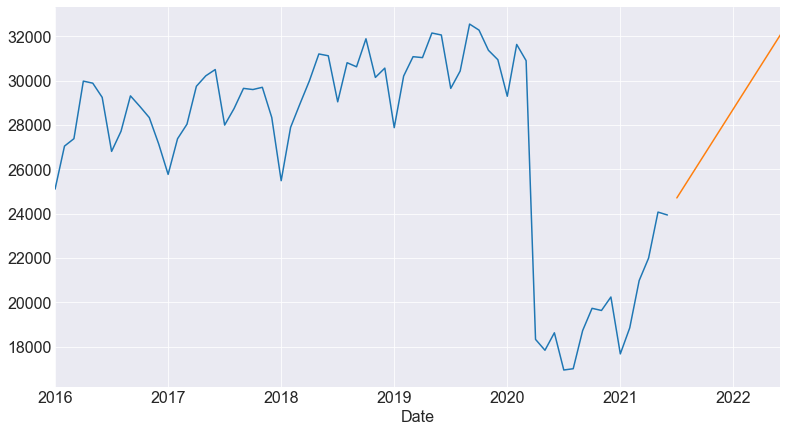

In [371]:
# make adjusted predictions
holts = model.predict(start = future_index[0], end = future_index[-1])
s_perform.plot()
holts.plot()

##### Last normal season 

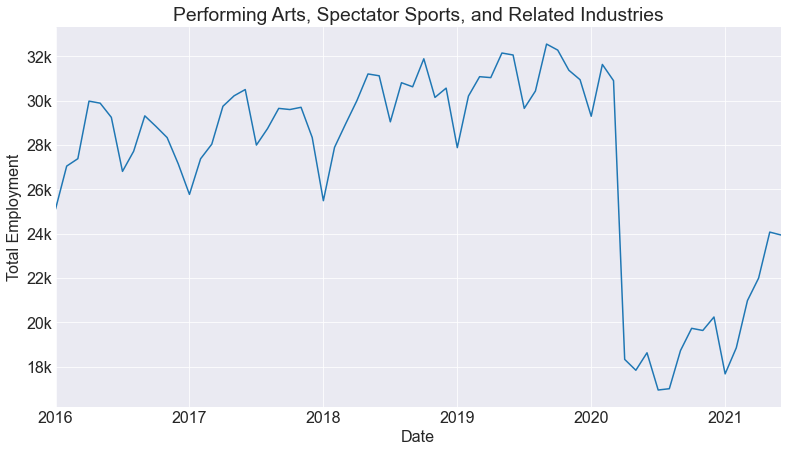

In [372]:
# forecast pre-COVID behavior after full recovery
s_perform = forecast_ind_dict['Performing Arts, Spectator Sports, and Related Industries']
s_perform.plot()
plt.gca().set(ylabel = 'Total Employment', title='Performing Arts, Spectator Sports, and Related Industries')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));

##### Splits

In [373]:
train = s_perform['2016' : '2018']
test = s_perform['2019']

In [374]:
# create a function to visualize splits
def viz_splits(train, test):
    ax = train.plot(label='train')
    test.plot(ax=ax, label='test')
    plt.legend()
    plt.title('Visualizing Splits')
    plt.ylabel('Total Employment')
    ax.yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
    plt.show();

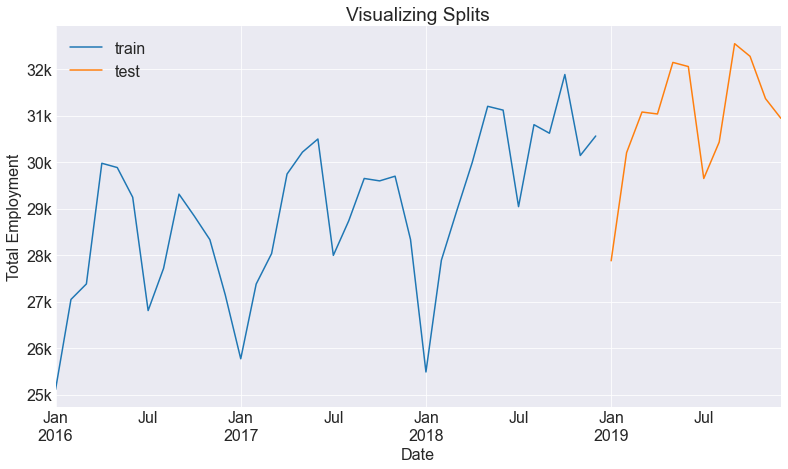

In [375]:
viz_splits(train, test)

##### Seasonal Decomp 

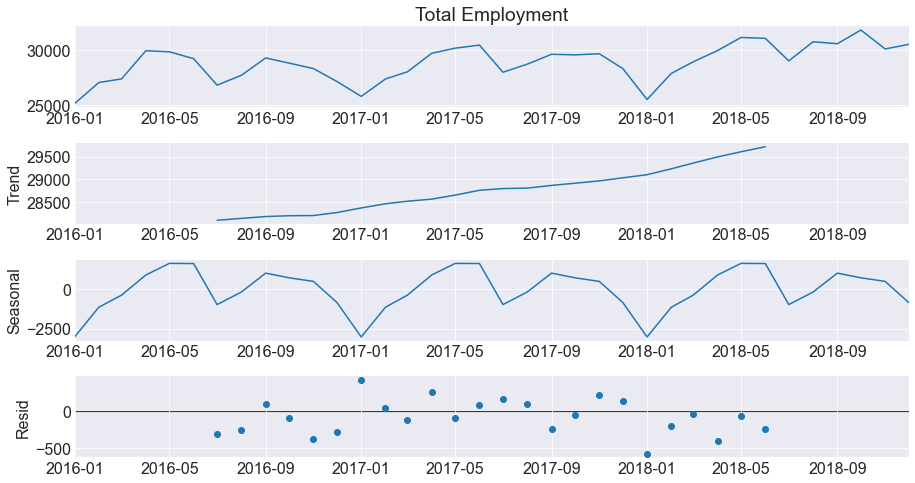

In [376]:
_ = sm.tsa.seasonal_decompose(train).plot()

##### Forecast and Test

In [390]:
forecast = train['2016'] + 3*(train.diff(12).mean())
forecast.index = test.index

In [391]:
train.diff(12).mean()

871.75

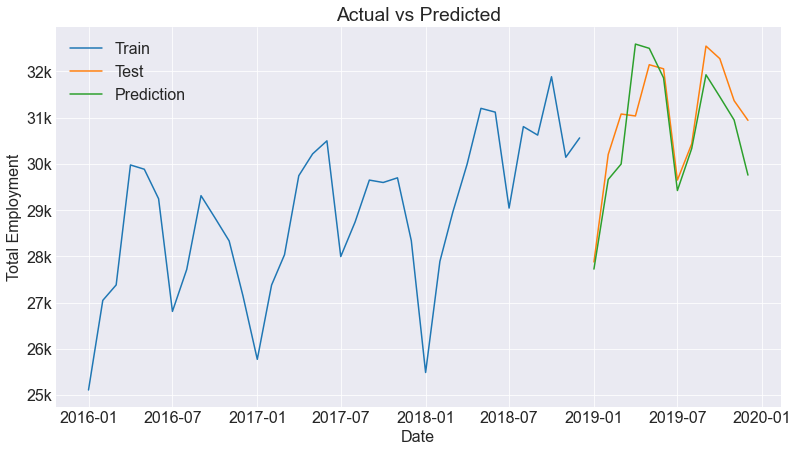

In [392]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Date')
plt.ylabel('Total Employment')
plt.plot(forecast, label = 'Prediction')
plt.title('Actual vs Predicted')
plt.legend()
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000))
plt.show()

In [393]:
# get RMSE
mean_squared_error(test, forecast, squared=False)

751.4251875602787

In [394]:
# get R^2
explained_variance_score(test, forecast)

0.697056465451893

##### Predict Future

In [397]:
# predict the future
# want to predict into future to get us to end of year 2023
# get values for respective months preceding pandemic 2018-11 to 2019-12
historical = s_perform['2018-07' : '2019-12']

In [398]:
# want to get index that goes from July 2021 to Dec 2022

future_index_str = [
    '2022-07', 
    '2022-08',
    '2022-09', 
    '2022-10',
    '2022-11', 
    '2022-12', 
    '2023-01', 
    '2023-02', 
    '2023-03',
    '2023-04',
    '2023-05',
    '2023-06',
    '2023-07',
    '2023-08',
    '2023-09',
    '2023-10',
    '2023-11',
    '2023-12'
    ]

future_index = pd.to_datetime(future_index_str)

future_index

DatetimeIndex(['2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', freq=None)

In [399]:
future = historical + train.diff(12).mean()
# still need to reset the index
future.index = future_index

<AxesSubplot:xlabel='Date'>

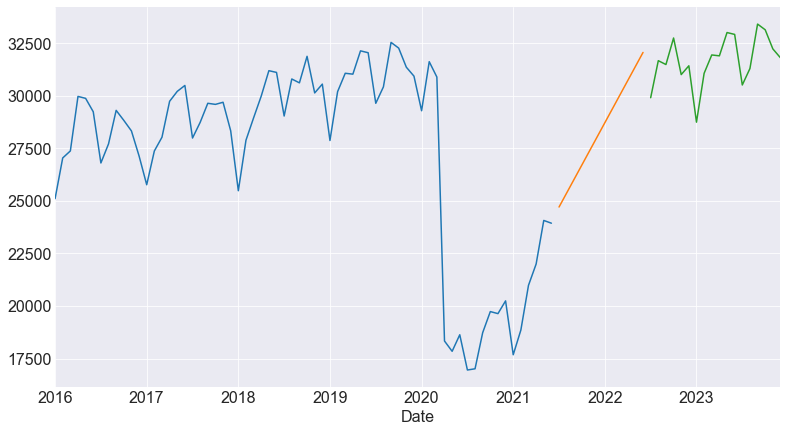

In [400]:
s_perform.plot()
holts.plot()
future.plot()

##### Final Plot

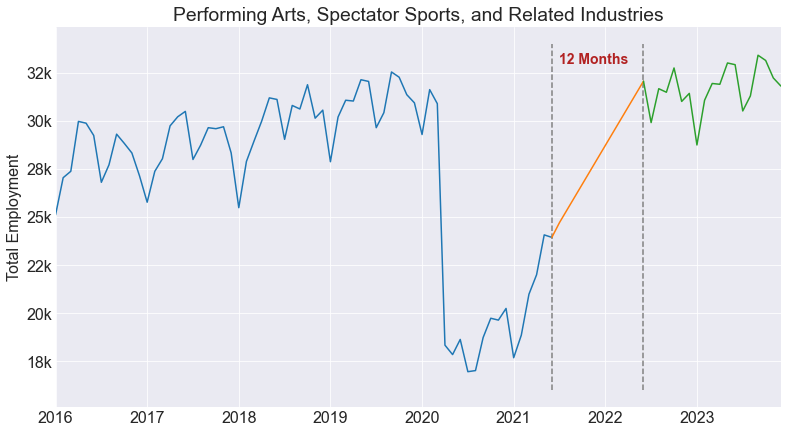

In [416]:
full_forecast = pd.concat([s_perform, holts, future])
full_forecast[ : '2021-06'].plot() # data we have
full_forecast['2021-06' : '2022-06'].plot() # linear recovery forecast
full_forecast['2022-06' : ].plot() # resumption forecast
plt.vlines(x='2021-06', ymin=16_000, ymax=34_000, linestyles='--', colors='gray')
plt.vlines(x='2022-06', ymin=16_000, ymax=34_000, linestyles='--', colors='gray')
plt.text('2021-07', 33_000, '12 Months', fontsize=14, color='firebrick', fontweight='bold')
plt.gca().set(title='Performing Arts, Spectator Sports, and Related Industries', 
              ylabel='Total Employment')
plt.gca().yaxis.set_major_formatter(lambda x, pos: '{:.0f}k'.format(x / 1_000));